## 0. Inicjalizacja

#### 0.1 Import

In [130]:
import pandas as pd
import os
import sys
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, train_test_split
from time import time
from scipy.stats import randint
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
sys.path.append(os.path.abspath("../"))
from src.utils import load_train_test_data
from src.pipeline import build_pipeline

#### 0.2 Parametry oraz Dataset

In [104]:
with open("../params.yaml", "r") as file:
    params = yaml.safe_load(file)

In [105]:
training_data, _ = load_train_test_data("../data/train_test_data")
training_data = training_data[params["features"]["selected"]]
training_data = training_data[0:1000]
X_train, X_val, y_train, y_val = train_test_split(training_data.drop(columns=["LABEL-rating"], axis=1), training_data["LABEL-rating"], test_size=0.2)

2025-04-11 11:08:24 - INFO - Loading train and test data


#### 0.3 Pipeline

In [106]:
base_rf = RandomForestClassifier(n_jobs=-1)
pipeline = build_pipeline(params, "all", base_rf)

#### 0.4 Funkcja do eksperymentów

In [107]:
def run_search(name, searcher, X_train, X_val, y_train, y_val):
    print('Fit...')
    start = time()
    searcher.fit(X_train, y_train)
    end = time()

    elapsed = end - start
    best_model = searcher.best_estimator_
    n_models = len(searcher.cv_results_["mean_test_score"])
    best_params = searcher.best_params_
    best_score = searcher.best_score_

    print('Predict...')
    y_pred = best_model.predict(X_val)

    results = {
        "Method": name,
        "Best f1_weighted (CV)": best_score,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_val, y_pred, average="weighted", zero_division=0),
        "F1 (weighted)": f1_score(y_val, y_pred, average="weighted", zero_division=0),
        "Time (s)": elapsed,
        "Models Tried": n_models,
        "Best Params": best_params,
        "Best Estimator": best_model
    }

    return searcher, results

#### 0.5 Parametry do eksperymentów

In [ ]:
distributions = {
    "classifier__n_estimators": randint(30, 60),
    "classifier__max_depth": randint(10, 50),
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_leaf": randint(1, 7),
    "classifier__max_features": ["sqrt", None]
}

In [ ]:
param_grid = {
    "classifier__n_estimators": [30, 60],
    "classifier__max_depth": [10, 30, 50],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_leaf": [1, 5],
    "classifier__max_features": ["sqrt", None]
}

## 1. RandomSearch

#### 1.1 Opis działania, możliwości, ograniczenia

**[RandomizedSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)** losowo wybiera kombinacje hiperparametrów z podanego rozkładu lub listy wartości. Można ustawić liczbę iteracji, co pozwala kontrolować czas trwania wyszukiwania.

- Dzięki losowości jest szybszy od GridSearch, lecz przeszukuje mniejszą przestrzeń hiperparametrów.
Może wciąż znaleźć bardzo dobre parametry przy mniejszej złożoności obliczeniowej

- Wynik zależy od losowości, ponieważ może pominąć najlepsze hiperparametry.
- Wyniki mogą się różnić przy wielu próbach uruchomienia przez losowość

#### 1.2 Jakość najlepszego modelu oraz czas działania

In [110]:
clf = RandomizedSearchCV(pipeline, distributions, return_train_score=True, scoring='f1_weighted', n_jobs=-1, n_iter=40)
randomized_searcher, randomized_results = run_search("RandomizedSearchCV", clf, X_train, X_val, y_train, y_val)

Fit...
Predict...


#### 1.3 Liczba iteracji metody

Liczba iteracji jest równa parametrowi n_iter.

In [111]:
print(f'RandomizedSearchCV wykonał {randomized_results["Models Tried"]} pomiarów')

RandomizedSearchCV wykonał 40 pomiarów


## 2. GridSearch

#### 2.1 Opis działania, możliwości, ograniczenia

[GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) przeszukuje wybrane przestrzenie hiperparametrów tworząc iloczyn kartezjański na podanych wartościach hiperparametrów. 

- Dzięki temu bardzo precyzyjnie możemy oszacować, które wartości nas potencjalnie najbardziej interesują oraz możemy bardzo dokładnie przeszukać przestrzeń hiperaparametrów.
- Deterministyczny oraz bardzo dokładny

- Bardzo wymagający obliczeniowo, dokonanie tylu eksperymentów ile podano wartości oraz list wartości.
- Bardzo wymgający czasowo.

#### 2.2 Jakość najlepszego modelu oraz czas działania

In [112]:
clf = GridSearchCV(pipeline, param_grid, return_train_score=True, scoring='f1_weighted', n_jobs=-1)
grid_searcher, grid_results = run_search("GridSearchCV", clf, X_train, X_val, y_train, y_val)

Fit...
Predict...


#### 2.3 Liczba iteracji metody

Liczba pomiarów jest równa iloczynowi liczebności każdej z list hiperparametrów

In [113]:
print(f'GridSearchCV wykonał {grid_results["Models Tried"]} pomiarów')

GridSearchCV wykonał 72 pomiarów


## 3. HalvingGridSearch

#### 3.1 Opis działania, możliwości, ograniczenia

[HalvingGridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) działa analogicznie do GridSearch'a, lecz optymalizuje swoje działanie poprzez wykonywanie eksperymentów na części danych. Na początku testuje wiele kombinacji na małych próbkach danych, a w kolejnych iteracjach zwiększa ilość danych tylko dla najlepszych kandydatów.

- Posida zalety grid searcha dokładnego przeszukania przestrzeni hiperparametrów przy mniejszym nakładzie mocy obliczeniowej oraz krótszym czasie wykonywania.
- Utrzymuje dokładność GridSearch przy mniejszych kosztach.

- Wadą jest fakt, iż jest to eksperymentalna funkcja sklearn, czyli nie jest ustabilizowana/może się zmieniać.
- Wciąż przeszukujemy ogromną liczbę zbiorów hiperparametrów

#### 3.2 Jakość najlepszego modelu oraz czas działania

In [114]:
clf = HalvingGridSearchCV(pipeline, param_grid, return_train_score=True, scoring='f1_weighted', n_jobs=-1)
halv_grid_searcher, halv_grid_results = run_search("HalvingGridSearchCV", clf, X_train, X_val, y_train, y_val)

Fit...
Predict...


#### 3.3 Liczba iteracji metody

In [115]:
print(f'GridSearchCV wykonał {halv_grid_results["Models Tried"]} pomiarów')

GridSearchCV wykonał 104 pomiarów


## 4. HalvingRandomSearch

#### 4.1 Opis działania, możliwości, ograniczenia

[HalvingRandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html) jest połączeniem HalvingGridSearch oraz RandomSeach. Działa z mechanizmem losowego wyboru hiperparametrów z aspektem odsiewania słabszych i trenowania pozostałych na większej liczbie danych.

Najbardziej efektywny czasowo i najmniej wymagający obliczeniowo

Ponownie jest eksperymentalną funkcja sklearn oraz tak jak RandomSearch może pominąć najlepsze wartości hiperparametrów

#### 4.2 Jakość najlepszego modelu oraz czas działania

In [116]:
clf = HalvingRandomSearchCV(pipeline, param_grid, return_train_score=True, scoring='f1_weighted', n_jobs=-1, n_candidates=40)
halv_rand_grid_searcher, halv_rand_grid_results = run_search("HalvingRandomSearchCV", clf, X_train, X_val, y_train, y_val)

Fit...
Predict...


#### 4.3 Liczba iteracji metody

In [117]:
print(f'GridSearchCV wykonał {halv_rand_grid_results["Models Tried"]} pomiarów')

GridSearchCV wykonał 59 pomiarów


## 5. Podsumowanie

#### 5.1 Porównanie modeli

In [120]:
results = [randomized_results, grid_results, halv_grid_results, halv_rand_grid_results]
df_results = pd.DataFrame(results)

In [167]:
df_results

,Method,Best f1_weighted (CV),Accuracy,Precision,Recall,F1 (weighted),Time (s),Models Tried,Best Params,Best Estimator,Time per Model
0,RandomizedSearchCV,0.547348,0.675,0.561267,0.675,0.576364,43.568027,40,"{'classifier__criterion': 'entropy', 'classifi...","(ColumnTransformer(transformers=[('cat', OneHo...",1.089201
1,GridSearchCV,0.514334,0.670,0.448900,0.670,0.537605,35.403318,72,"{'classifier__criterion': 'gini', 'classifier_...","(ColumnTransformer(transformers=[('cat', OneHo...",0.491713
2,HalvingGridSearchCV,0.504404,0.670,0.448900,0.670,0.537605,34.003409,104,"{'classifier__criterion': 'gini', 'classifier_...","(ColumnTransformer(transformers=[('cat', OneHo...",0.326956
3,HalvingRandomSearchCV,0.503162,0.670,0.448900,0.670,0.537605,17.901776,59,"{'classifier__n_estimators': 200, 'classifier_...","(ColumnTransformer(transformers=[('cat', OneHo...",0.303420


d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pan

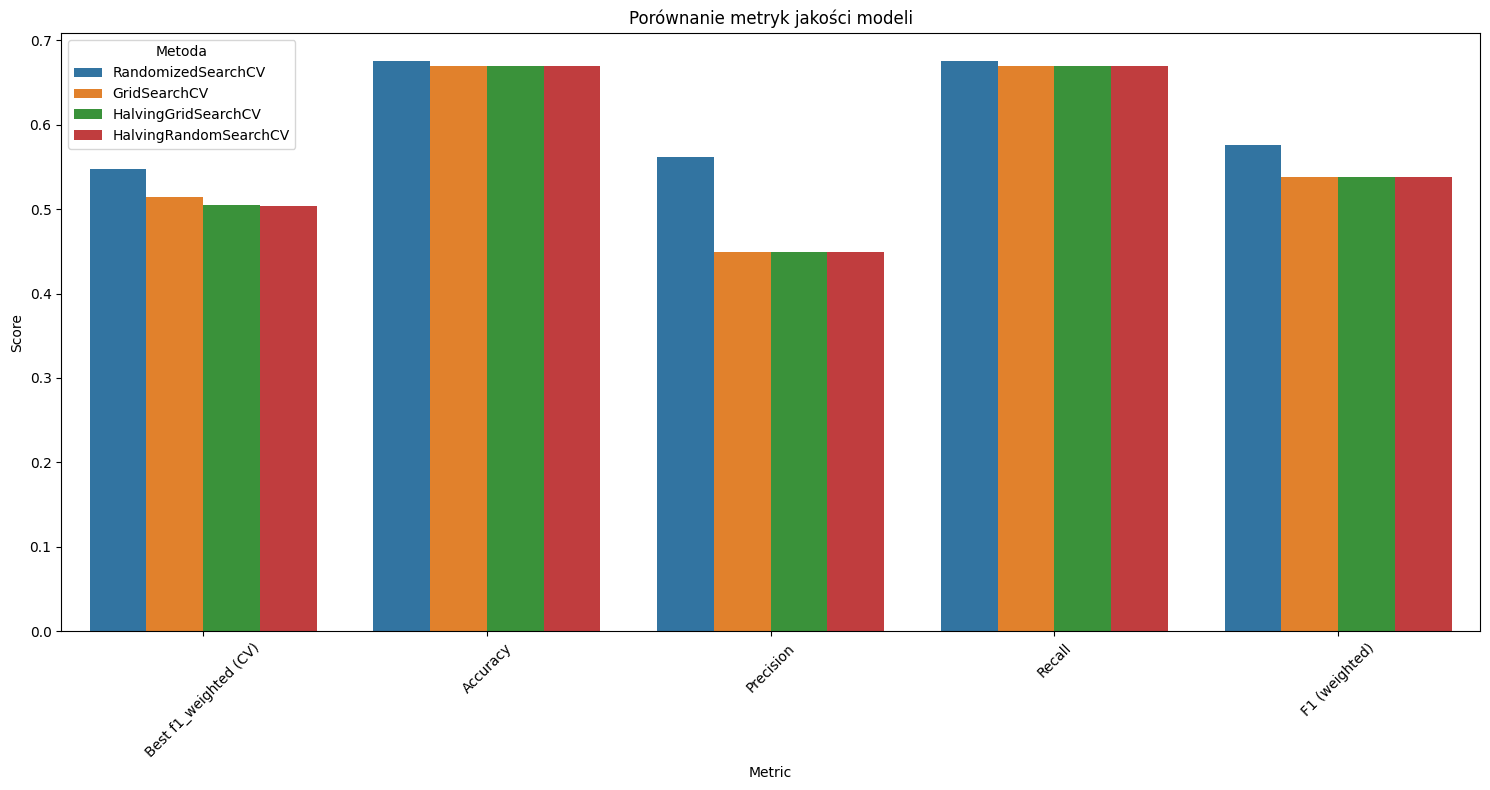

In [156]:
plt.figure(figsize=(15, 8))
metrics_to_plot = ["Best f1_weighted (CV)", "Accuracy", "Precision", "Recall", "F1 (weighted)"]
df_melted = df_results.melt(id_vars="Method", value_vars=metrics_to_plot, var_name="Metric", value_name="Score")

sns.barplot(data=df_melted, x="Metric", y="Score", hue="Method")
plt.title("Porównanie metryk jakości modeli")
plt.xticks(rotation=45)
plt.legend(title="Metoda")
plt.tight_layout()
plt.show()


d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pan

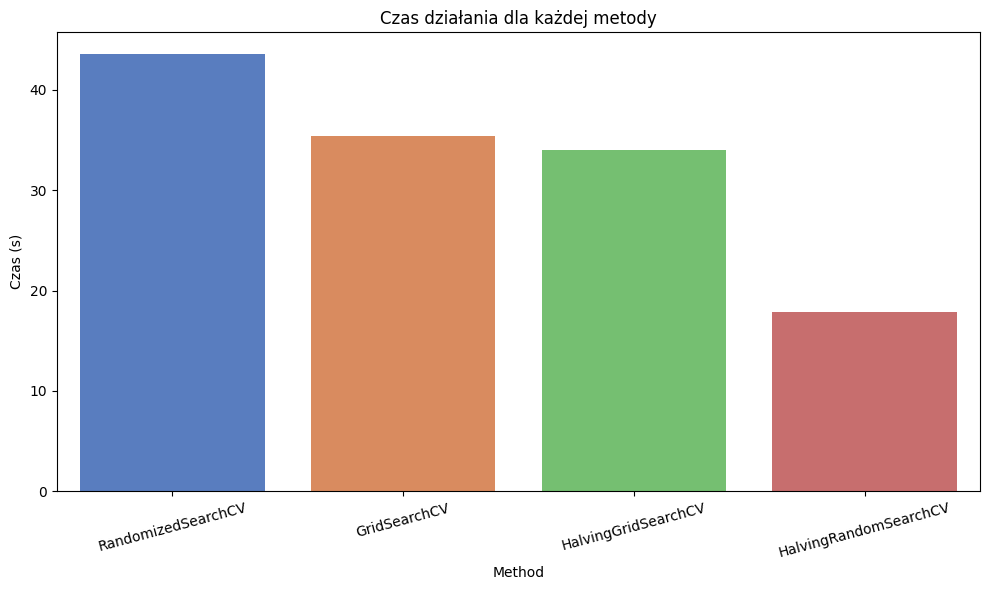

In [166]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Method", y="Time (s)", palette="muted", hue="Method")
plt.title("Czas działania dla każdej metody")
plt.ylabel("Czas (s)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
df_results["Time per Model"] = df_results["Time (s)"] / df_results["Models Tried"]

d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\studia\Przetwarzanie Danych i Odkrywanie Wiedzy\summer-25-lab3-6-TytanMikJas\.venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pan

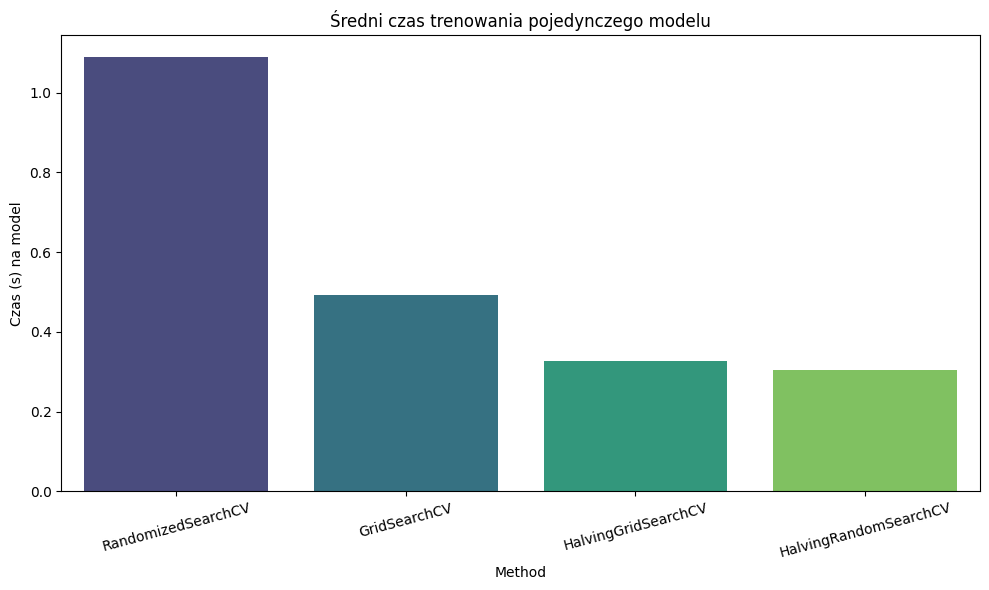

In [162]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Method", y="Time per Model", hue="Method", palette="viridis", legend=False)
plt.title("Średni czas trenowania pojedynczego modelu")
plt.ylabel("Czas (s) na model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


#### 5.2 Porównanie wyników

Najlepsze wyniki osiągnął model Randomized Search z 
- avg f1(weighted)	0.55	
- best accuracy 0.68
- best recall	0.56
- best precision	0.68	
- best f1 0.58

Model trenował się najwięcej czasu oraz posiada najgorszą metrykę względem czasu/model

Pozostałe metody osiągnęły bardzo podobne wyniki, lecz różniły je czasy wykonywania.

Zakładająć, iż wyniki bybły nieznacznie podobne kolejny model z najlepszymi wynikami posiada HalvingRandomSearch ze względu na definitywnie najkrótszy czas działania.

#### 5.3 Wybrów i uzasadnienie

Nie ma jednego dobrego wyjścia, są one bardzo zależne od naszych potrzeb i kompetencji.

Najlepszą opcją, gdy potrzebujemy szybko znaleźć "dobry" model jest zdecydowanie HalvingRandomSearch ze względu na akceptowalne wyniki w zaskakująco krótkim czasie. (Dobre wyniki, szybkie działanie).

Najlepszym wyborem, gdy znamy dokładnie model, dane oraz posiadamy dużą wiedzę dziedzinową i intuicję jest GridSearch ze względu na możliwość dokładnego zbadania wielu hiperparametrów dla naszej hipotezy. (Najlepszy wynik, najdłużej się wykonuje).

Najlepszym wyborem, gdy nie do końca znamy potencjalne hiperparametry oraz nie zależy nam na czasie jest RandomizedSearch dzięki któremu w sposób losowy możemy osiąganąć dobre wyniki dla modelu oraz samemu zdecydować ilu iteracji potrzebujemy.

Dla mnie, jako studenta bez silnej intuicji odnośnie nieznanych klasyfikatorów i dla nieznanyc zbiorów danych najlepszą opcją byłby HalvingRandomSearch, ponieważ umożliwiłby mi w szybki sposób zrozumieć dla jakich mniej więcej parametrów model działałby dobrze.